# Pivot Point

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest 
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Pivot_Point import Pivot_Point, PrepareData
from util.Save_result_return import save_to_csv

## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [15]:
from backtesting import Strategy
import numpy as np
import pandas as pd
from util.ATR import *
from util.SMA import *
from util.Bollinger_bands import *
from util.load_data import *


def PrepareData(data):
    agg_dict = {"Open": "first",
                "High": "max",
                "Low": "min",
                "Close": "last"
                }
    daily_data = data.resample("D", offset="16H").agg(agg_dict).dropna()
    daily_data.columns = ["Open_d", "High_d", "Low_d", "Close_d"]
    data = pd.concat([data, daily_data.shift().dropna()],
                     axis=1).ffill().dropna()
    return data


class Pivot_Point(Strategy):
    periods = 14
    moving_av = 3

    def init(self):

        self.data.df["PP"] = (
            self.data.df["High_d"] + self.data.df["Low_d"] + self.data.df["Close_d"]) / 3
        self.data.df["S1"] = self.data.df["PP"] * 2 - self.data.df["High_d"]
        self.data.df["S2"] = self.data.df["PP"] - \
            (self.data.df["PP"] - self.data.df["PP"])
        self.data.df["R1"] = self.data.df["PP"] * 2 - self.data.df["Low_d"]
        self.data.df["R2"] = self.data.df["PP"] + \
            (self.data.df["High_d"] - self.data.df["Low_d"])

        self.data.df["position"] = np.where(
            self.data.df["Open"] > self.data.df["PP"], 1, -1)
        self.data.df["position"] = np.where(
            self.data.df["Open"] >= self.data.df["R1"], 0, self.data.df["position"])
        self.data.df["position"] = np.where(
            self.data.df["Open"] <= self.data.df["S1"], 0, self.data.df["position"])

    def next(self):
        position = self.data.df.loc[self.data.df.index[-1], 'position']
        if position == 1:
            if self.position.is_short:
                self.position.close()
            self.buy(size=1)
        elif position == 0:
            self.position.close()
        elif position == -1:
            if self.position.is_long:
                self.position.close()
            self.sell(size=1)

In [16]:
strategy = Pivot_Point

In [17]:
account_size = 10000

## Prepare Data

In [7]:
data_D1 = PrepareData(XAUUSD['D1'])
data_H4 = PrepareData(XAUUSD['H4'])
data_H1 = PrepareData(XAUUSD['H1'])
data_M30 = PrepareData(XAUUSD['M30'])


In [18]:
data_H4 = PrepareData(XAUUSD['H4'])

In [8]:
# data_M15 = PrepareData(XAUUSD['M15'])
# data_M5 = PrepareData(XAUUSD['M5'])
# data_M1 = PrepareData(XAUUSD['M1'])

# Backtest each time frame

## TF D1

In [9]:
Backtest_D1 = Backtest(data_D1, strategy, cash=account_size, margin=1/100,  commission=0.0002 )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 16:00:00
End                       2023-03-10 00:00:00
Duration                   5911 days 08:00:00
Exposure Time [%]                    99.97025
Equity Final [$]                  7838.154016
Equity Peak [$]                  11416.803386
Return [%]                          -21.61846
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -1.498632
Volatility (Ann.) [%]                8.554612
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -40.156216
Avg. Drawdown [%]                   -2.030029
Max. Drawdown Duration     4203 days 08:00:00
Avg. Drawdown Duration      154 days 15:00:00
# Trades                                 6054
Win Rate [%]                        43.425834
Best Trade [%]                      11.713105
Worst Trade [%]                     -9.308321
Avg. Trade [%]                    

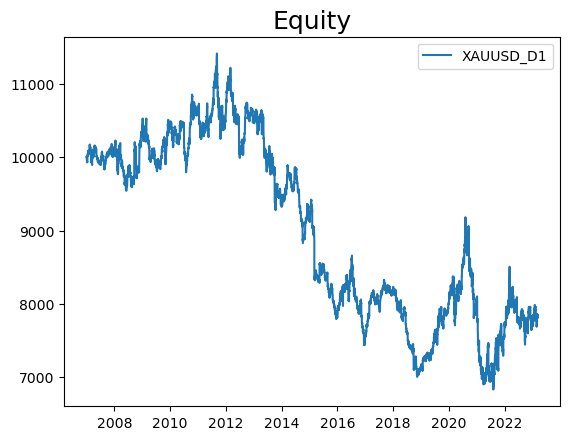

In [10]:
plot_equity_trades(result_D1['_equity_curve'], 'XAUUSD_D1' , account_size)

### Save output

In [11]:
save_to_csv(result_D1, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_D1.csv')  

## TF H4

In [19]:
Backtest_H4 = Backtest(data_H4, strategy, cash= account_size, margin=1/100 , commission= 0.0002)
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 16:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                    89.97987
Equity Final [$]                  7346.907122
Equity Peak [$]                  11596.909937
Return [%]                         -26.530929
Buy & Hold Return [%]              193.102239
Return (Ann.) [%]                   -1.528203
Volatility (Ann.) [%]                9.084926
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -54.202878
Avg. Drawdown [%]                   -1.970621
Max. Drawdown Duration     4125 days 16:00:00
Avg. Drawdown Duration      111 days 09:00:00
# Trades                                21756
Win Rate [%]                        45.049641
Best Trade [%]                      10.820957
Worst Trade [%]                      -6.32406
Avg. Trade [%]                    

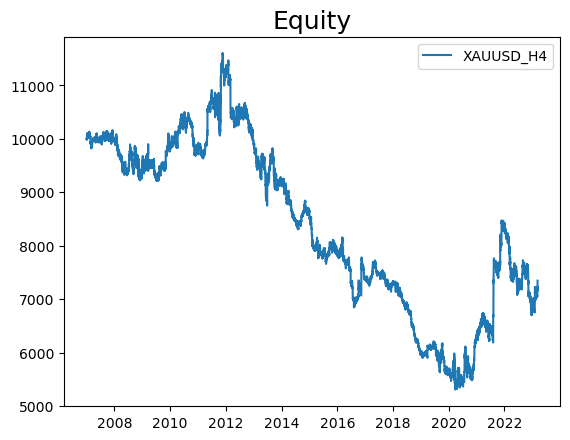

In [20]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4', account_size)

### Save output

In [14]:
save_to_csv(result_H4, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_H4.csv')  

## TF H1

In [15]:
Backtest_H1 = Backtest(data_H1, strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 16:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 01:00:00
Exposure Time [%]                   99.997976
Equity Final [$]                 12897.051675
Equity Peak [$]                  20991.011608
Return [%]                          28.970517
Buy & Hold Return [%]              193.053396
Return (Ann.) [%]                    1.278715
Volatility (Ann.) [%]               22.134887
Sharpe Ratio                         0.057769
Sortino Ratio                           0.087
Calmar Ratio                         0.018905
Max. Drawdown [%]                  -67.640032
Avg. Drawdown [%]                   -1.404885
Max. Drawdown Duration     4068 days 02:00:00
Avg. Drawdown Duration       33 days 18:00:00
# Trades                                62679
Win Rate [%]                        52.180156
Best Trade [%]                      10.979018
Worst Trade [%]                     -7.398817
Avg. Trade [%]                    

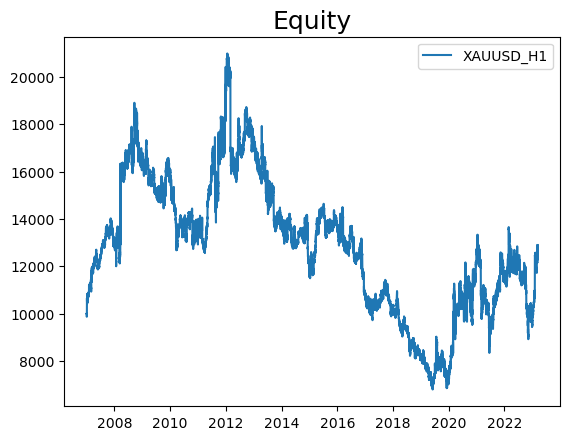

In [16]:
plot_equity_trades(result_H1['_equity_curve'], 'XAUUSD_H1', account_size)

### Save output

In [17]:
save_to_csv(result_H1, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_H1.csv')  

## TF M30 

In [18]:
Backtest_M30 = Backtest(data_M30, strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 16:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 01:30:00
Exposure Time [%]                   50.986693
Equity Final [$]                          0.0
Equity Peak [$]                  24811.258389
Return [%]                             -100.0
Buy & Hold Return [%]               193.27378
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               103.91221
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -1.578255
Max. Drawdown Duration     4053 days 08:30:00
Avg. Drawdown Duration       23 days 04:05:00
# Trades                                65273
Win Rate [%]                        54.060638
Best Trade [%]                       7.932716
Worst Trade [%]                     -7.826335
Avg. Trade [%]                    

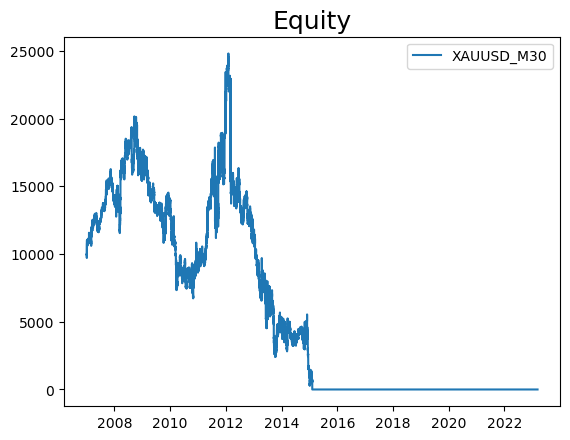

In [19]:
plot_equity_trades(result_M30['_equity_curve'], 'XAUUSD_M30', account_size)

### Save output

In [20]:
save_to_csv(result_M30, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_M30.csv')  

## TF M15

In [21]:
Backtest_M15 = Backtest(data_M15, strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_M15 = Backtest_M15.run()
result_M15

NameError: name 'data_M15' is not defined

In [ ]:
plot_equity_trades(result_M15['_equity_curve'], 'XAUUSD_M15', account_size)

### Save output

In [ ]:
save_to_csv(result_M15, '../../out/Technical_Strategy/Pivot_Point//Backtest/result_M15.csv')  